# Images of Dogs and images without Dogs
All code thanks to Dr Ilmi Yoon! 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow.keras
import numpy as np
%matplotlib inline 
import itertools

print("Importing was successful !!!")

Importing was successful !!!


#Configuring the Virtual Interpreter
The colab environment runs code cells on a virtual cloud computer owned by Google. To ensure that the code is executed efficiently, GPU (graphics processing) must be enabled:

Navigate to 'Runtime' > 'Change Runtime Type'
Ensure that 'Hardware Accelerator' is set to 'GPU'
Once you have performed these steps, the output of the code cell below should read 'GPU 0' followed by the name of the graphics processor.

In [ ]:
import os 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest'
os.listdir(data_dir)

['testing', 'validation', 'training']

In [ ]:
train_path = data_dir+'/training'
valid_path = data_dir+'/validation/'
test_path = data_dir+'/testing/'

In [ ]:
image_size = (224, 224)
classes = ['Dogs','No Dogs']
print("Training:")
train_batches = ImageDataGenerator() \
                  .flow_from_directory(train_path,
                                       image_size,
                                       classes=classes,
                                       batch_size=5)
print("Validation:")
valid_batches = ImageDataGenerator() \
                  .flow_from_directory(valid_path,
                                       image_size,
                                       classes=classes,
                                       batch_size=5)
print("Testing:")
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     image_size,
                                     classes=classes,
                                     batch_size=5)

Training:
Found 56 images belonging to 2 classes.
Validation:
Found 27 images belonging to 2 classes.
Testing:
Found 30 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


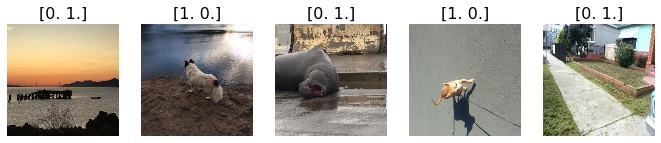

In [ ]:
# plots images with labels
def plots(ims, figsize=(14,14), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)

plots(imgs[0:5], titles=labels)

#Creating the Model
In Keras, the deep learning model is represented by layers of processing. After importing a pretrained model, a new model is created using this model. All of these layers are copied from the pretrained model to the new model. However, the final output layer will be replaced and retrained using the labeled data, esssentially customizing the output for this specific classification task.

#Loading a Pretrained Model
A pretrained VGG16 model is downloaded using the Keras library.

In [ ]:
vgg16_model = tensorflow.keras.applications.VGG16()

In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#Creating a Custom Output Model
A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model. This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribution adding up to unity. In mathematics, the softmax function, also known as softargmax or normalized exponential function, is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities proportional to the exponentials of the input numbers. Therefore, our model will output a probability distribution among the classes as output for each input image.

In [ ]:
print(classes)

['Dogs', 'No Dogs']


In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

model.add(Dense(len(classes), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

#Training the Model
Now that the model has been specified, it must be trained to detect hyenas and wild dogs images.

#Compiling the Model
In preparation for training, the model is compiled. In order to train it, we must evaluate its performance using a loss function. This function is designed to increase as performance decreases. Therefore, in training, we are essentially minimizing the value of the loss function. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a numerical value, the correct loss function would be 'mean_squared_error'.

In [ ]:
model.compile(Adam(lr=.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("It is done")

It is done


#Minimizing Loss
The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.

In [ ]:
valid_batches.samples/5

5.4

In [ ]:
model.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 5, #Ilmi had 15 here, I made it 5
     validation_data = valid_batches, 
     validation_steps = valid_batches.samples // 5,
     epochs=10, 
     verbose=1)
print("Training Complete!")

Epoch 1/10
11/11 [==============================] - 1s 62ms/step - loss: 0.1905 - accuracy: 0.9216 - val_loss: 0.5779 - val_accuracy: 0.8000
Epoch 2/10
11/11 [==============================] - 1s 50ms/step - loss: 0.1838 - accuracy: 0.9216 - val_loss: 0.3296 - val_accuracy: 0.8400
Epoch 3/10
11/11 [==============================] - 1s 49ms/step - loss: 0.1640 - accuracy: 0.9608 - val_loss: 0.5665 - val_accuracy: 0.8000
Epoch 4/10
11/11 [==============================] - 1s 51ms/step - loss: 0.1478 - accuracy: 0.9804 - val_loss: 0.5083 - val_accuracy: 0.8400
Epoch 5/10
11/11 [==============================] - 1s 50ms/step - loss: 0.1289 - accuracy: 0.9804 - val_loss: 0.5811 - val_accuracy: 0.8000
Epoch 6/10
11/11 [==============================] - 1s 49ms/step - loss: 0.1134 - accuracy: 0.9804 - val_loss: 0.5920 - val_accuracy: 0.8400
Epoch 7/10
11/11 [==============================] - 1s 50ms/step - loss: 0.0989 - accuracy: 0.9804 - val_loss: 0.6017 - val_accuracy: 0.8000
Epoch 8/10
11

#Testing the Model
To perform a final test of the model, the test data is fed through the model. It is important to use data what was removed from the training set so we can test the performance accurately. The accuracy (percentage of images classified correctly) is calculated and a confusion matrix is generated.

In [ ]:
test_batches.samples

30

In [ ]:
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     image_size,
                                     classes = classes,
                                     batch_size = test_batches.samples,
                                     shuffle = False) # all images in the test dataset
test_loss, test_acc = model.evaluate(test_batches,
                                     steps=1, 
                                     verbose=0) 
print(test_loss)
print(test_acc) 

Found 30 images belonging to 2 classes.
0.08405633270740509
1.0


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Confusion matrix, without normalization
[[13  0]
 [ 0 17]]


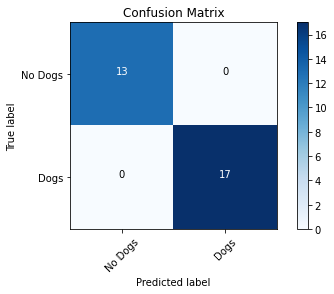

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#test_batches.reset()
test_imgs, test_labels = next(test_batches)
test_labels = test_labels[:,0]
predictions = model.predict(test_batches, steps=1, verbose=0)
print(np.round(test_labels)) #Can I print the labels for the test dataset?
print(np.round(predictions[:,0]))
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

cm_plot_labels = classes[::-1]
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

#Looking at the test images and their labels

In [ ]:
labels_pred= np.round(predictions[:,0])
falsenegatives = np.where(np.logical_and(test_labels == 1, labels_pred == 0)) 
print(falsenegatives)
falsepositives = np.where(np.logical_and(test_labels == 0, labels_pred == 1)) 
print(falsepositives)

(array([], dtype=int64),)
(array([], dtype=int64),)


In [ ]:
test_path

'/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/'

In [ ]:
#Make a list of the images file paths for the test images
listTestImages = []
for j in range(2):
  for i in range(len(os.listdir(test_path+classes[j]))):
    filename = os.listdir(test_path+classes[j])[i]
    listTestImages.append(test_path +  classes[j] + '/' + filename)

for i in range(len(listTestImages)):
  print(i)
  print(listTestImages[i])


0
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/IMG_1380.JPG
1
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/20180609_095437.jpg
2
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/20.jpg
3
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/4.jpg
4
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/IMG_2585.jpeg
5
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/18.jpg
6
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/20191222_085242.jpg
7
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/20191223_113821.jpg
8
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/7.jpg
9
/content/drive/My Drive/Images_EDSS_2021/Mod_4_Proj/Dogs_NoDogsTrValTest/testing/Dogs/2020010

In [ ]:
realLabel="Dog"
predictedLabel = "Dog"
for i in range(len(listTestImages)):
    print(i)
    if test_labels[i] <0.5: 
      realLabel = "No Dog"
    if test_labels[i] >0.5: 
      realLabel = "Dog"
    if labels_pred[i] <0.5: 
      predictedLabel = "No Dog"
    if labels_pred[i] >0.5: 
      predictedLabel = "Dog"  
    print("label:" + realLabel + ", prediction: " + predictedLabel)
    #print(labels_pred[i] )
    filename = listTestImages[i]
    img_file = plt.imread(filename)
    #plt.imshow(img_file)
    #plt.show()

0
label:Dog, prediction: Dog
1
label:Dog, prediction: Dog
2
label:Dog, prediction: Dog
3
label:Dog, prediction: Dog
4
label:Dog, prediction: Dog
5
label:Dog, prediction: Dog
6
label:Dog, prediction: Dog
7
label:Dog, prediction: Dog
8
label:Dog, prediction: Dog
9
label:Dog, prediction: Dog
10
label:Dog, prediction: Dog
11
label:Dog, prediction: Dog
12
label:Dog, prediction: Dog
13
label:Dog, prediction: Dog
14
label:Dog, prediction: Dog
15
label:Dog, prediction: Dog
16
label:Dog, prediction: Dog
17
label:No Dog, prediction: No Dog
18
label:No Dog, prediction: No Dog
19
label:No Dog, prediction: No Dog
20
label:No Dog, prediction: No Dog
21
label:No Dog, prediction: No Dog
22
label:No Dog, prediction: No Dog
23
label:No Dog, prediction: No Dog
24
label:No Dog, prediction: No Dog
25
label:No Dog, prediction: No Dog
26
label:No Dog, prediction: No Dog
27
label:No Dog, prediction: No Dog
28
label:No Dog, prediction: No Dog
29
label:No Dog, prediction: No Dog


In [ ]:
realLabel="Dog"
predictedLabel = "Dog"
for i in range(len(listTestImages)):
    if test_labels[i] <0.5: 
      realLabel = "No Dog"
    if test_labels[i] >0.5: 
      realLabel = "Dog"
    if labels_pred[i] <0.5: 
      predictedLabel = "No Dog"
    if labels_pred[i] >0.5: 
      predictedLabel = "Dog"  
    print("label:" + realLabel + ", prediction: " + predictedLabel)
    #print(labels_pred[i] )
    filename = listTestImages[i]
    img_file = plt.imread(filename)
    plt.imshow(img_file)
    plt.show()
    print("")
    print("")

Output hidden; open in https://colab.research.google.com to view.